In [2]:
import os
import pandas as pd

In [3]:
def read_log_file(path, filename):
    
    """Function for reading logs with training process"""
    with open(os.path.join(path, filename), 'r') as f:
        data = f.read()
        data = data.rstrip().split('\n')
        data = list(map(lambda x: x.rstrip().split('\t'), data))[1:]
        train_RMSE = list(map(lambda x: float(x[0]), data))
        train_R2 = list(map(lambda x: float(x[2]), data))
        val_RMSE = list(map(lambda x: float(x[1]), data))
        val_R2 = list(map(lambda x: float(x[3]), data))
        return train_RMSE, train_R2, val_RMSE, val_R2

In [4]:
def plot_training_process(num_exp = '', \
                          logs_path = '../../../data/raw/baselines/neuralfingerprint/logs/exp_'+'', \
                          logs_filename_prefix =  ''+'_logs_metrics', \
                          logs_test_fin_file = ''+'_logs.txt', \
                          parameters_file = ''+'_parameters.json'):
    import matplotlib.pyplot as plt
    import json
    
    
    
    try:
        train_RMSE_conv, train_R2_conv, val_RMSE_conv, val_R2_conv = \
        read_log_file(logs_path, logs_filename_prefix+'_conv.txt')  
        train_RMSE_morgan, train_R2_morgan, val_RMSE_morgan, val_R2_morgan = \
        read_log_file(logs_path, logs_filename_prefix+'_morgan.txt') 
        
        with open(os.path.join(logs_path, logs_test_fin_file)) as f:
            data = f.read().rstrip().split('\n\n')[-1].split('\n')
            if len(data) == 3:
                test_R2 = float(data[-1].split(' ')[-1])
                test_RMSE = None
            elif len(data)==4:
                test_R2 = float(data[-2].split(' ')[-1])
                test_RMSE = float(data[-1].split(' ')[-1])
            elif len(data)==1:
                test_R2=None
                test_RMSE=None

        with open(os.path.join(logs_path, parameters_file)) as f:
            params = json.load(f)
            dataset_name = params['data_file']
            fp_length = params['fp_length']
    except (IOError, ValueError) as e:
        return None, None
        
    fig, ax = plt.subplots(2,2, figsize = (10,10), sharey='row', sharex='col')

    ax[0,0].plot(train_RMSE_conv, label='train')
    ax[0,0].plot(val_RMSE_conv, label = 'val')
    ax[0,0].set_ylabel('RMSE')
    ax[0,0].set_title('Neural Fingerprints')


    ax[1,0].plot(train_R2_conv, label='train')
    ax[1,0].plot(val_R2_conv, label = 'val')
    ax[1,0].set_xlabel('Iterations/10')
    ax[1,0].set_ylabel('R2')
    ax[1,0].set_ylim(-0.5,1)


    ax[0,1].plot(train_RMSE_morgan, label='train')
    ax[0,1].plot(val_RMSE_morgan, label = 'val')
    ax[0,1].set_title('Morgan Fingerprints')

    ax[1,1].plot(train_R2_morgan, label='train')
    ax[1,1].plot(val_R2_morgan, label = 'val')
    ax[1,1].set_xlabel('Iterations/10')


    for i in range(2):
        for j in range(2):
            ax[i,j].legend()

    
    title = 'Experiment ' + str(num_exp) + \
            '\n'+'Dataset: '+dataset_name + \
            '\n'+'Fingerprint length: '+str(fp_length)
    if test_R2 is not None:
        title = title + '\ntest R2 score = ' + str(round(test_R2, 2))
    if test_RMSE is not None:
        title = title + '\ntest RMSE score = ' + str(round(test_RMSE, 2))
    fig.suptitle(title)
    
    plt.show()
    
    return fig, ax

In [5]:
def summary_table(num_exp = range(4,8), logs_path = '../../../data/raw/baselines/neuralfingerprint/logs',\
                  logs_postfix = '_logs.txt',):
    import pandas as pd
    import os
    import json
    
    summary = []
    
    for NUM_EXP in num_exp:
        try:
            with open(os.path.join(logs_path, 'exp_'+str(NUM_EXP), str(NUM_EXP)+'_parameters.json')) as f:
                summary.append(json.load(f))
            with open(os.path.join(logs_path, 'exp_'+str(NUM_EXP), str(NUM_EXP)+logs_postfix)) as f:
                data = f.read().rstrip().split('\n\n')[-1].split('\n')
                if len(data) == 3:
                    conv_test_R2 = float(data[-1].split(' ')[-1])
                    avg_test_R2 = float(data[-2].split(' ')[-1])
                    morgan_test_R2 = float(data[-3].split(' ')[-1])
                    conv_test_RMSE = None
                elif len(data)==4:
                    conv_test_R2 = float(data[-2].split(' ')[-1])
                    avg_test_R2 = float(data[-3].split(' ')[-1])
                    morgan_test_R2 = float(data[-4].split(' ')[-1])
                    conv_test_RMSE = float(data[-1].split(' ')[-1])
                elif len(data)==1:
                    summary = summary[:-1]
                    continue
                summary[-1]['Neural Fingerprint test R2'] = conv_test_R2
                summary[-1]['Neural Fingerprint test RMSE'] = conv_test_RMSE
                summary[-1]['Average test R2'] = avg_test_R2
                summary[-1]['Morgan Fingerprint test R2'] = morgan_test_R2
            train_RMSE_conv, train_R2_conv, val_RMSE_conv, val_R2_conv = \
            read_log_file(logs_path+'/exp_'+str(NUM_EXP), str(NUM_EXP)+'_logs_metrics'+'_conv.txt')  
            train_RMSE_morgan, train_R2_morgan, val_RMSE_morgan, val_R2_morgan = \
            read_log_file(logs_path+'/exp_'+str(NUM_EXP), str(NUM_EXP)+'_logs_metrics'+'_morgan.txt') 
        except (IOError, ValueError) as e:
            summary = summary[:-1]
            continue
        summary[-1]['Neural Fingerprint train RMSE'] = train_RMSE_conv[-1]
        summary[-1]['Neural Fingerprint val RMSE'] = val_RMSE_conv[-1]
        summary[-1]['Neural Fingerprint train R2'] = train_R2_conv[-1]
        summary[-1]['Neural Fingerprint val R2'] = val_R2_conv[-1]
        
        summary[-1]['Morgan Fingerprint train RMSE'] = train_RMSE_morgan[-1]
        summary[-1]['Morgan Fingerprint val RMSE'] = val_RMSE_morgan[-1]
        summary[-1]['Morgan Fingerprint train R2'] = train_R2_morgan[-1]
        summary[-1]['Morgan Fingerprint val R2'] = val_R2_morgan[-1]
        
        summary[-1]['num_iters'] = len(train_R2_conv)*10

    return pd.DataFrame(summary)
        

# Plot training process

In [17]:
NUM_EXPs = list(map(lambda x: x.split('_')[1], os.listdir('../../../data/raw/baselines/neuralfingerprint/logs')))
del NUM_EXPs[NUM_EXPs.index('checkpoints')]

In [18]:
NUM_EXPs = list(filter(lambda x: int(x)>=200, NUM_EXPs))

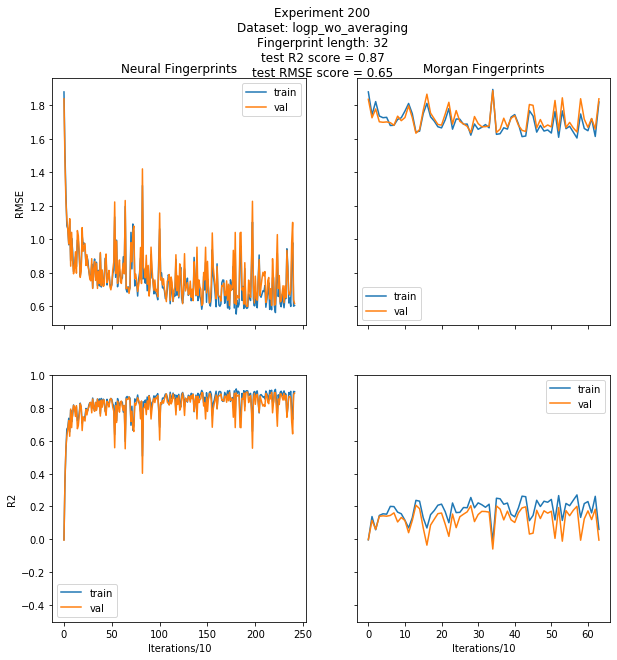

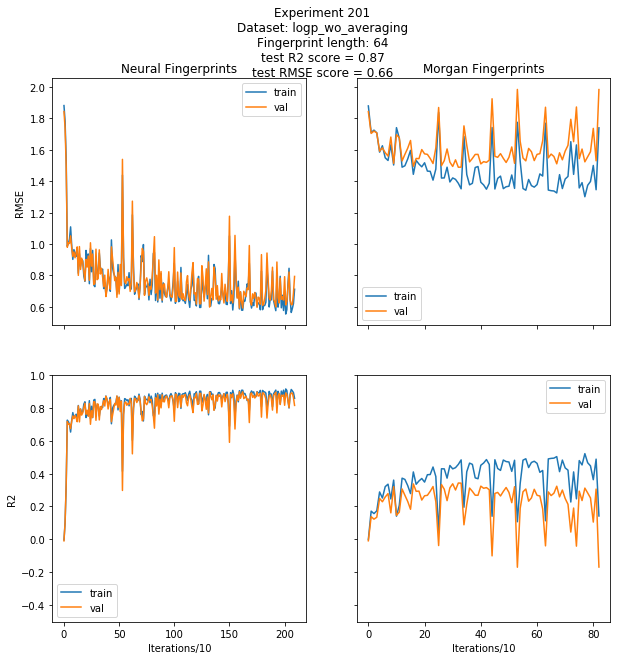

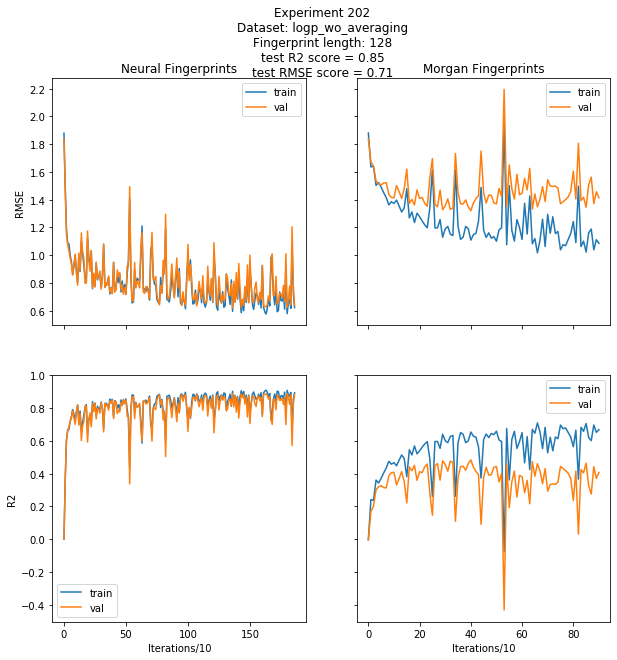

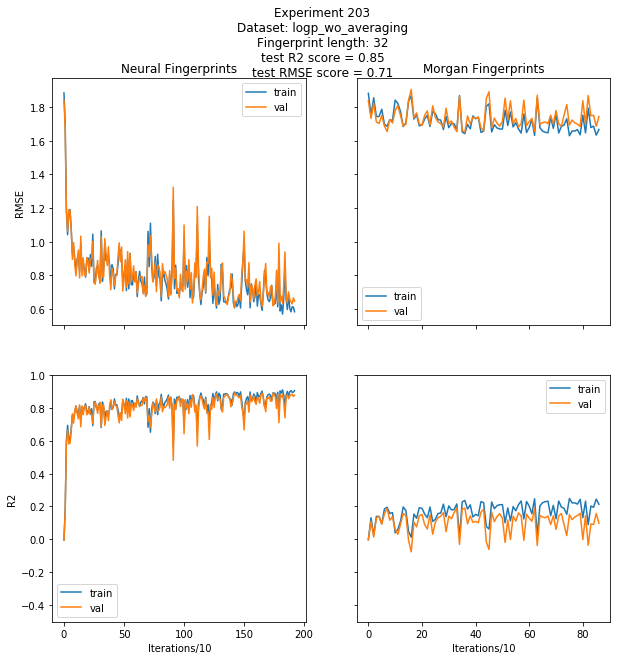

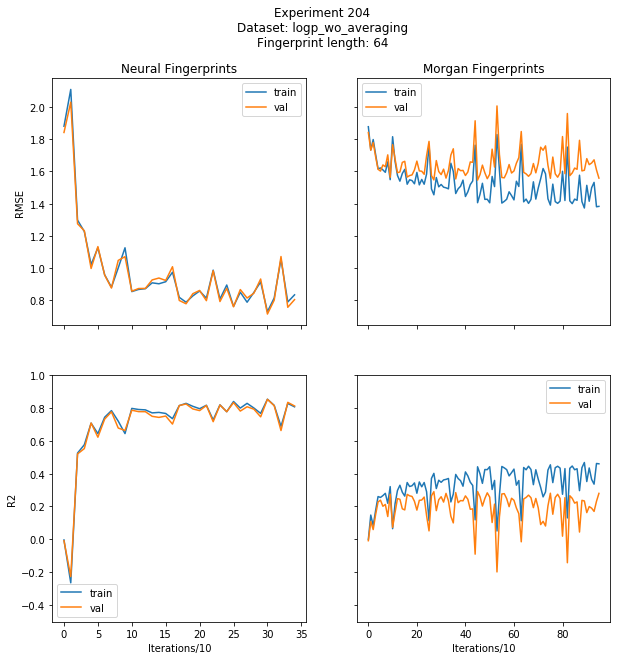

In [19]:
for NUM_EXP in NUM_EXPs:
    _ = plot_training_process(num_exp = NUM_EXP, \
                              logs_path = '../../../data/raw/baselines/neuralfingerprint/logs/exp_'+str(NUM_EXP), \
                              logs_filename_prefix =  str(NUM_EXP)+'_logs_metrics', \
                              logs_test_fin_file = str(NUM_EXP)+'_logs.txt', \
                              parameters_file = str(NUM_EXP)+'_parameters.json')

# Create table with summary

In [20]:
experiment_info_table = summary_table(num_exp = NUM_EXPs).sort_values(by='Neural Fingerprint test RMSE', ascending=True)
scores = list(filter(lambda x: 'Fingerprint' in x, list(experiment_info_table)))
for score in scores:
    experiment_info_table[score] = \
    experiment_info_table[score].apply(lambda x: round(x, 4))
# nunique = experiment_info_table.apply(pd.Series.nunique)
# cols_to_drop = nunique[nunique == 1].index
# experiment_info_table_changed_parameters = experiment_info_table.drop(cols_to_drop, axis=1)
experiment_info_table_changed_parameters = experiment_info_table
experiment_info_table_changed_parameters = experiment_info_table_changed_parameters.set_index('NUM_EXP')
experiment_info_table_changed_parameters = experiment_info_table_changed_parameters[[
 'fp_length',
 'data_file',
 'num_iters',
 'fp_depth',
 'conv_width',
 'learn_rate',                                                                                    
 'Neural Fingerprint test RMSE',                                                                                    
 'Neural Fingerprint test R2',
 'Morgan Fingerprint test R2',
 'Neural Fingerprint train RMSE',
 'Neural Fingerprint val RMSE',
 'Neural Fingerprint train R2',
 'Neural Fingerprint val R2',
 'Morgan Fingerprint train RMSE',
 'Morgan Fingerprint val RMSE',
 'Morgan Fingerprint train R2',
 'Morgan Fingerprint val R2']]

In [21]:
experiment_info_table_changed_parameters

,fp_length,data_file,num_iters,fp_depth,conv_width,learn_rate,Neural Fingerprint test RMSE,Neural Fingerprint test R2,Morgan Fingerprint test R2,Neural Fingerprint train RMSE,Neural Fingerprint val RMSE,Neural Fingerprint train R2,Neural Fingerprint val R2,Morgan Fingerprint train RMSE,Morgan Fingerprint val RMSE,Morgan Fingerprint train R2,Morgan Fingerprint val R2
NUM_EXP,,,,,,,,,,,,,,,,,
200,32,logp_wo_averaging,2420,3,10,-3.0,0.6535,0.8732,-0.0821,0.6029,0.6147,0.8971,0.8879,1.8211,1.8399,0.0610,-0.0040
201,64,logp_wo_averaging,2100,3,10,-3.0,0.6582,0.8713,-0.1796,0.7107,0.7926,0.8570,0.8137,1.7403,1.9842,0.1425,-0.1677
203,32,logp_wo_averaging,1930,4,10,-3.0,0.7087,0.8508,0.0667,0.5842,0.6467,0.9034,0.8759,1.6667,1.7436,0.2134,0.0983
202,128,logp_wo_averaging,1870,3,10,-3.0,0.7089,0.8508,0.2739,0.6225,0.6366,0.8903,0.8798,1.0856,1.4143,0.6663,0.4068


In [22]:
with open('../../../data/raw/experiments_result','w') as f:
    f.write(experiment_info_table_changed_parameters.to_markdown())

In [18]:
experiment_info_table_sum = experiment_info_table_changed_parameters[[
 'data_file',
 'Neural Fingerprint test RMSE',  
 'Neural Fingerprint test R2',
 'Neural Fingerprint val RMSE',
 'Neural Fingerprint val R2',
 'Neural Fingerprint train RMSE',
 'Neural Fingerprint train R2',
]]

In [19]:
experiment_info_table_sum

,data_file,Neural Fingerprint test RMSE,Neural Fingerprint test R2,Neural Fingerprint val RMSE,Neural Fingerprint val R2,Neural Fingerprint train RMSE,Neural Fingerprint train R2
NUM_EXP,,,,,,,
60,logp_mean,0.61,0.90,0.68,0.87,0.61,0.89
126,logp_mean,0.66,0.88,0.80,0.81,0.78,0.83
102,logp_mean,0.67,0.88,0.80,0.81,0.77,0.83
152,logp_mean,0.67,0.88,0.84,0.80,0.81,0.81
116,logp_mean,0.68,0.87,0.86,0.78,0.84,0.79
...,...,...,...,...,...,...,...
19,logP_wo_parameters,NaN,0.72,0.60,0.89,0.60,0.89
50,logp_mean,NaN,0.53,1.22,0.56,1.20,0.58
51,logP_wo_parameters,NaN,0.80,0.85,0.77,0.85,0.78


In [125]:
with open('../../../data/raw/experiments_result','w') as f:
    f.write(experiment_info_table_sum.to_markdown())